In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
G = nx.read_weighted_edgelist("Contact-diaries-network_data_2013.csv", nodetype=int)

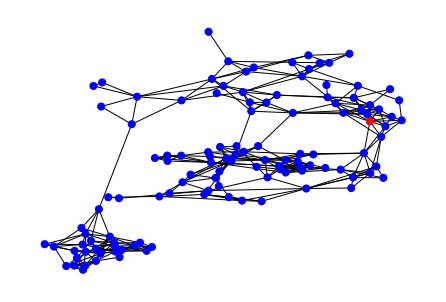

In [11]:
nx.draw(G, **opt)

Esta función sirve para "abrir" aristas después de un tiempo agendado de apertura. Se toma el mayor de los tiempos agendados para abrir la arista. 

In [3]:
def open_edge(event, H):
    #event is (0: time, 1: edge, 2:type)
    if H.edges[event[1]]['sched_reopen'] > event[0]:
        return(1)
    else:
        H.edges[event[1]]['status'] = 'open'

Función de recuperación de los nodos, que toma un nodo y cambia su estado a "recuperado". Se abre el contacto con todos los vecinos del nodo que tienen un estado distinto de infectado.

In [4]:
def process_recovery(event, H, times, S, I, R): 
    #events are (0: time, 1: node, 2: type)

    H.nodes[event[1]]['status'] = 'recovered'
    times.append(event[0])
    S.append(S[-1])
    I.append(I[-1]-1)
    R.append(R[-1]+1)
    
    #esta es la parte donde se abren las aristas
    for nb in H.neighbors(event[1]):
        if H.nodes[nb]['status'] != 'infected':
            H[nb][event[1]]['state'] = 'open'

Función de transmisión, toma al nodo y cambia su estado de susceptible a infectado. Se toma una fracción de sus vecinos y se cierran los contactos entre ellos.

In [5]:
def process_transmission(event,H, times, S, I, R, list_of_events, beta, beta_fm, gamma, Tmax): 
    
    #beta contagion rate or infection rate or transmission rate
    #gamma recovery rate
    #beta_fm rate or infection rate of people that use facemask, is less than beta.
    
    #events are (0: time, 1: node, 2: type)
    if H.nodes[event[1]]['status'] == 'susceptible':

        H.nodes[event[1]]['status'] = 'infected'

        times.append(event[0])
        S.append(S[-1]-1)
        I.append(I[-1]+1)
        R.append(R[-1])
        
        to_close = round(H.nodes[event[1]]['isolation']*H.degree(event[1]))
        
        edges_to_close = random.sample(list(H.edges(event[1])), to_close)
        
        #nuevo
        for edge in edges_to_close:
            H.edges[edge]['state'] = 'close'
            t = event[0]+random.expovariate(1)
            if t > H.edges[edge]['sched_reopen']:
                H.edges[edge]['sched_reopen'] = t
                reopen_edge = (t, edge, 'open') 
                list_of_events.append(reopen_edge)
                list_of_events.sort()

        rec_time = event[0] + random.expovariate(gamma)

        if rec_time < Tmax:
            new_event = (rec_time, event[1], 'recovery')
            list_of_events.append(new_event)
            list_of_events.sort()

        for target in H.neighbors(event[1]):
            if H.nodes[target]['status'] == 'susceptible' and H[target][event[1]]['state'] == 'open':
                if H.nodes[target]['facemask'] == False:
                    inf_time = event[0] + random.expovariate(beta)
                else:
                    inf_time = event[0] + random.expovariate(beta_fm)
         

                if inf_time < min(rec_time, H.nodes[target]['pred_inf_time'], Tmax):
                    new_event = (inf_time, target, 'transmit')
                    list_of_events.append(new_event)
                    list_of_events.sort()
                    H.nodes[target]['pred_inf_time'] = inf_time            

In [6]:
def epidemic(H,beta,beta_fm,gamma,Tmax,isolation,fm_percentage):
    if(nx.is_connected(H)==False):
        raise ValueError("Graph H must be connected")
    
    list_of_events = []
    times, S, I, R = [0], [len(H.nodes)], [0], [0]
    
    
    for e in H.edges:
        H.edges[e]['state'] = 'open'
        H.edges[e]['sched_reopen'] = 0
        
    
    
    for u in H.nodes:
        H.nodes[u]['status'] = 'susceptible'
        H.nodes[u]['pred_inf_time'] = np.inf
        H.nodes[u]['facemask'] = False
        #H.nodes[u]['isolation'] = random.random()
        
        #Agregar una característica a los agentes para que tengan un perfil y en base a ese perfil se decide si se aisla y/o usa cubrebocas.
        
        x=random.random()
        if x<.516:
            H.nodes[u]['risk-aversion'] = 'risk-loving'
            H.nodes[u]['isolation'] = isolation[0]
        elif x < .662:
            H.nodes[u]['risk-aversion'] = 'risk-neutral'
            H.nodes[u]['isolation'] = isolation[1]
        elif x < .908:
            H.nodes[u]['risk-aversion'] = 'midly-risk-averse'
            H.nodes[u]['isolation'] = isolation[2]
        else:
            H.nodes[u]['risk-aversion'] = 'highly-risk-averse'
            H.nodes[u]['isolation'] = isolation[3]
   
    #risk-loving
    rl = [i for i in H.nodes if H.nodes[i]['risk-aversion'] == 'risk-loving']
    fm_fraction = round(fm_percentage[0]*(len(rl)))
    fm_use = random.sample(rl,fm_fraction)
    
    for u in fm_use:
        H.nodes[u]['facemask'] = True 
    
    #risk-neutral
    rn = [i for i in H.nodes if H.nodes[i]['risk-aversion'] == 'risk-neutral']
    fm_fraction = round(fm_percentage[1]*(len(rn)))
    fm_use = random.sample(rn,fm_fraction)
    
    for u in fm_use:
        H.nodes[u]['facemask'] = True 
        
    #midly-risk-averse
    mra = [i for i in H.nodes if H.nodes[i]['risk-aversion'] == 'midly-risk-averse']
    fm_fraction = round(fm_percentage[2]*(len(mra)))
    fm_use = random.sample(mra,fm_fraction)
    
    for u in fm_use:
        H.nodes[u]['facemask'] = True 
        
    #highly-risk-averse
    hra = [i for i in H.nodes if H.nodes[i]['risk-aversion'] == 'higly-risk-averse']
    fm_fraction = round(fm_percentage[3]*(len(hra)))
    fm_use = random.sample(hra,fm_fraction)
    
    for u in fm_use:
        H.nodes[u]['facemask'] = True 
    
        
    #initial infected
    u = np.random.choice(H.nodes, size=1)[0]
    H.nodes[u]['pred_inf_time'] = 0

    #events are (time, node, type)
    event = (0, u, 'transmit')

    list_of_events.append(event)
    list_of_events.sort()
    
    while(len(list_of_events) > 0):
        event = list_of_events.pop(0)
    
        if event[2] == 'transmit':
            process_transmission(event,H, times, S, I, R, list_of_events, beta, beta_fm, gamma, Tmax)
        elif event[2] == 'open':
            open_edge(event, H)
        else:
            process_recovery(event,H, times, S, I, R)
    
    network_data = np.column_stack((times, S, I, R))
    return(network_data)

In [30]:
data = np.array([0 for i in range(11)])

for fm_percentage in ([0,0.3,0.8,1],[0.05,0.3,0.8,1],[0.1,0.3,0.8,1],[0.15,0.3,0.8,1],[0.2,0.3,0.8,1],[0.25,0.3,0.8,1],[0.3,0.3,0.8,1],[0.35,0.3,0.8,1],[0.4,0.3,0.8,1],[0.45,0.3,0.8,1],[0.5,0.3,0.8,1]):
    g = []
    for isolation in ([0,0.1,0.5,0.9], [0.1,0.1,0.5,0.9], [0.2,0.1,0.5,0.9], [0.3,0.1,0.5,0.9], [0.4,0.1,0.5,0.9], [0.5,0.1,0.5,0.9], [0.6,0.1,0.5,0.9], 
                  [0.7,0.1,0.5,0.9], [0.8,0.1,0.5,0.9], [0.8,0.1,0.5,0.9], [1,0.1,0.5,0.9]):
        l = []
        for i in range(5000):
            l.append(epidemic(G, 1.5, 0.5, 1, 50, isolation, fm_percentage)[-1][-1])
        arr = np.array(l).mean()
        g.append(arr)
    data = np.vstack((data,g))
    
data = data[1:][:]

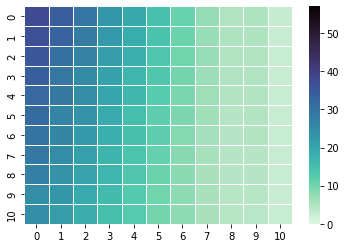

In [77]:
sns.heatmap(data, vmin=0, vmax=57,linewidths=.5,cmap="mako_r")
plt.savefig('plotx.png')

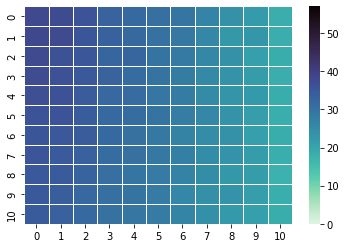

In [78]:
sns.heatmap(data1, vmin=0, vmax=57,linewidths=.5,cmap="mako_r")
plt.savefig('plotx1.png')

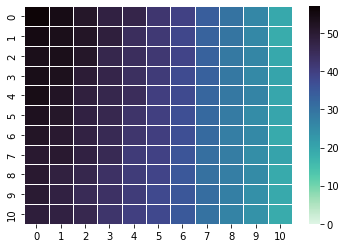

In [79]:
sns.heatmap(data2, vmin=0, vmax=57,linewidths=.5,cmap="mako_r")
plt.savefig('plotx2.png')

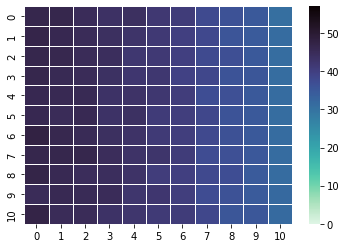

In [80]:
sns.heatmap(data3, vmin=0, vmax=57,linewidths=.5,cmap="mako_r")
plt.savefig('plotx3.png')

In [7]:
data1 = np.array([0 for i in range(11)])

for fm_percentage in ([0.1,0,0.8,1],[0.1,0.05,0.8,1],[0.1,0.1,0.8,1],[0.1,0.15,0.8,1],[0.1,0.2,0.8,1],[0.1,0.25,0.8,1],[0.1,0.3,0.8,1],[0.1,0.35,0.8,1],[0.1,0.4,0.8,1],[0.1,0.45,0.8,1],[0.1,0.5,0.8,1]):
    g = []
    for isolation in ([0.05,0,0.5,0.9], [0.05,0.1,0.5,0.9], [0.05,0.2,0.5,0.9], [0.05,0.3,0.5,0.9], [0.05,0.4,0.5,0.9], [0.05,0.5,0.5,0.9], [0.05,0.6,0.5,0.9], 
                  [0.05,0.7,0.5,0.9], [0.05,0.8,0.5,0.9], [0.05,0.9,0.5,0.9], [0.05,1,0.5,0.9]):
        l = []
        for i in range(5000):
            l.append(epidemic(G, 1.5, 0.5, 1, 50, isolation, fm_percentage)[-1][-1])
        arr = np.array(l).mean()
        g.append(arr)
    data1 = np.vstack((data1,g))
    
data1 = data1[1:][:]

In [24]:
data2 = np.array([0 for i in range(11)])

for fm_percentage in ([0.1,0.3,0,1],[0.1,0.3,0.05,1],[0.1,0.3,0.1,1],[0.1,0.3,0.15,1],[0.1,0.3,0.2,1],[0.1,0.3,0.25,1],[0.1,0.3,0.3,1],[0.1,0.3,0.35,1],[0.1,0.3,0.4,1],[0.1,0.3,0.45,1],[0.1,0.3,0.5,1]):
    g = []
    for isolation in ([0.05,0.1,0,0.9], [0.05,0.1,0.1,0.9], [0.05,0.1,0.2,0.9], [0.05,0.1,0.3,0.9], [0.05,0.1,0.4,0.9], [0.05,0.1,0.5,0.9], [0.05,0.1,0.6,0.9], 
                  [0.05,0.1,0.7,0.9], [0.05,0.1,0.8,0.9], [0.05,0.1,0.9,0.9], [0.05,0.1,1,0.9]):
        l = []
        for i in range(5000):
            l.append(epidemic(G, 1.5, 0.5, 1, 50, isolation, fm_percentage)[-1][-1])
        arr = np.array(l).mean()
        g.append(arr)
    data2 = np.vstack((data2,g))
    
data2 = data2[1:][:]

In [26]:
data3 = np.array([0 for i in range(11)])

for fm_percentage in ([0.1,0.3,0.8,0],[0.1,0.3,0.8,0.05],[0.1,0.3,0.8,0.1],[0.1,0.3,0.8,0.15],[0.1,0.3,0.8,0.2],[0.1,0.3,0.8,0.25],[0.1,0.3,0.8,0.3],[0.1,0.3,0.8,0.35],[0.1,0.3,0.8,0.4],[0.1,0.3,0.8,0.45],[0.1,0.3,0.8,0.5]):
    g = []
    for isolation in ([0.05,0.1,0.5,0], [0.05,0.1,0.5,0.1], [0.05,0.1,0.5,0.2], [0.05,0.1,0.5,0.3], [0.05,0.1,0.5,0.4], [0.05,0.1,0.5,0.5], [0.05,0.1,0.5,0.6], 
                  [0.05,0.1,0.5,0.7], [0.05,0.1,0.5,0.8], [0.05,0.1,0.5,0.9], [0.05,0.1,0.5,1]):
        l = []
        for i in range(5000):
            l.append(epidemic(G, 1.5, 0.5, 1, 50, isolation, fm_percentage)[-1][-1])
        arr = np.array(l).mean()
        g.append(arr)
    data3 = np.vstack((data3,g))
    
data3 = data3[1:][:]